In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t
import scipy.interpolate as inter

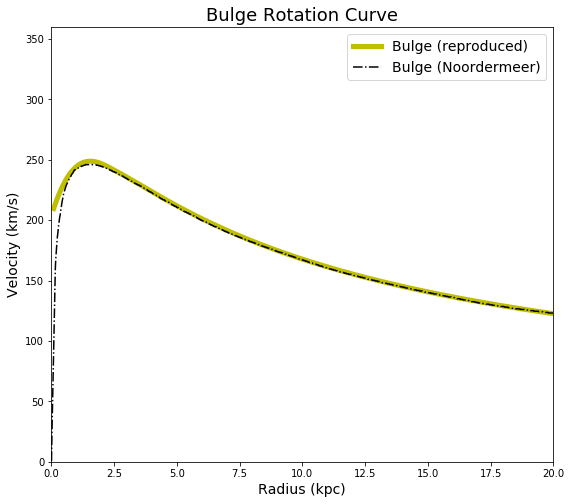

In [2]:
#bulge

data_bulge_nord = dp.getXYdata('data/final/nord-120kpc-bulge.txt')

#Bulge (Noordermeer's)
#convert to numpy arrays
r_b_nord = np.asarray(data_bulge_nord['xx'])
v_b_nord = np.asarray(data_bulge_nord['yy'])

#Plot 
fig = plt.figure(figsize=(9.0,8.0))

ax = plt.axes()
ax.set_title('Bulge Rotation Curve', fontsize=18)              #labeling axes
ax.set_xlabel('Radius (kpc)', fontsize=14)
ax.set_ylabel('Velocity (km/s)', fontsize=14)
#ax.grid(True)
plt.xlim(0,20)
plt.ylim(0,360)
rval = np.arange(0.1,200,0.1)

plt.plot(rval,nf.b_v(rval,load=True),color='y',label='Bulge (reproduced)',linewidth=5)
plt.plot(r_b_nord, v_b_nord, color='k', linestyle='-.', label='Bulge (Noordermeer)') 
plt.legend(fontsize=14)
#plt.show()
#plt.savefig('Reproducibility_Paper_Figures/bulge_comparison.png')

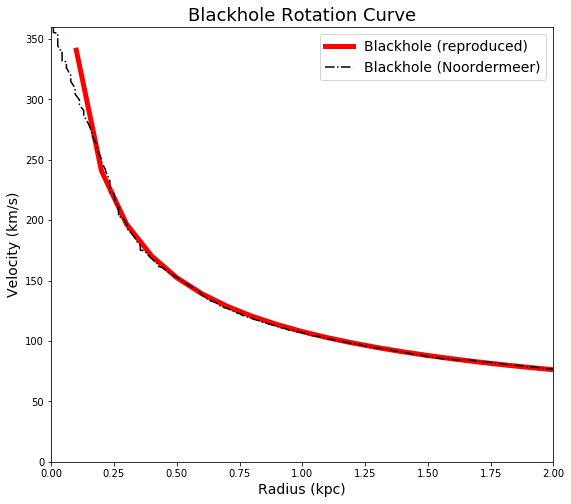

In [3]:
#blackhole

#data_bh_nord = dp.getXYdata('data/NGC5533-blackhole_fmt.txt')
data_bh_nord = dp.getXYdata('data/final/nord-120kpc-blackhole.txt')


#Black hole (Noordermeer's)
#convert to arrays
r_bh_nord = np.asarray(data_bh_nord['xx'])
v_bh_nord = np.asarray(data_bh_nord['yy'])



#Plot 
fig = plt.figure(figsize=(9.0,8.0))

ax = plt.axes()
ax.set_title('Blackhole Rotation Curve', fontsize=18)              #labeling axes
ax.set_xlabel('Radius (kpc)', fontsize=14)
ax.set_ylabel('Velocity (km/s)', fontsize=14)
#ax.grid(True)
plt.xlim(0,2)
plt.ylim(0,360)
rval = np.arange(0.1,200,0.1)

plt.plot(rval,nf.bh_v(rval,load=True),color='r',label='Blackhole (reproduced)',linewidth=5)
plt.plot(r_bh_nord, v_bh_nord, color='k', linestyle='-.', label='Blackhole (Noordermeer)') 
plt.legend(fontsize=14)
#plt.show()
#plt.savefig('Reproducibility_Paper_Figures/bh_comparison.png')

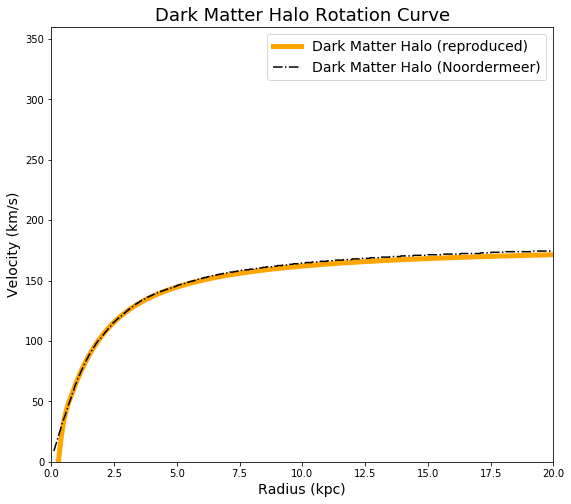

In [4]:
#halo

data_dm_nord = dp.getXYdata('data/final/nord-120kpc-halo.txt')

#Dark Matter Halo (Noordermeer's)
#convert to  arrays
r_dm_nord = np.asarray(data_dm_nord['xx'])
v_dm_nord = np.asarray(data_dm_nord['yy'])



#Plot 
fig = plt.figure(figsize=(9.0,8.0))

ax = plt.axes()
ax.set_title('Dark Matter Halo Rotation Curve', fontsize=18)              #labeling axes
ax.set_xlabel('Radius (kpc)', fontsize=14)
ax.set_ylabel('Velocity (km/s)', fontsize=14)
#ax.grid(True)
plt.xlim(0,20)
plt.ylim(0,360)
rval = np.arange(0.1,200,0.1)

plt.plot(rval,nf.h_v(rval,load=True),color='orange',label='Dark Matter Halo (reproduced)',linewidth=5)
plt.plot(r_dm_nord, v_dm_nord, color='k', linestyle='-.', label='Dark Matter Halo (Noordermeer)') 
plt.legend(fontsize=14)
#plt.show()
#plt.savefig('Reproducibility_Paper_Figures/halo_comparison.png')

In [5]:
#disk (new 100kpc data)
data_disk_nord = dp.getXYdata('data/final/nord-120kpc-disk.txt')



#Disk (Noordermeer's)
#convert to numpy arrays
r_d_nord = np.asarray(data_disk_nord['xx'])
v_d_nord = np.asarray(data_disk_nord['yy'])


In [6]:
#Uncertainty Band (ours)

# convert data to array
data = dp.getXYdata_wXYerr('data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

# create an array for the radius
rval = np.arange(0.1,200,0.1)

# make an empty array for a new velocity array to store velocity that's below 300 km/s 
# it seems Noordermeer ignored those points
v_dat_below300 = []

# when v_dat is above 300 km/s, replace it with 273 km/s
# average didn't seem to work as well
for v in range(len(v_dat)):
    if v_dat[v] < 300.0:
        v_dat_below300.append(v_dat[v])
    else:
        v_dat_below300.append(273)
        #v_dat_average = (v_dat[v-2] + v_dat[v+2])/2
        #v_dat_below300.append(v_dat_average)

# convert list to array
v_dat_below300 = np.array(v_dat_below300)

#print(v_dat_below300)

# this is just a guess for a delta_i that's changing with radius
#delta_i = 3+r_dat/4
delta_i = 3

# eq 4.2 on pg 168 in Noordermeer's thesis
#v_i = (v_dat_below300 / np.tan(52*(np.pi/180)) * delta_i *(np.pi/180))
v_i = (v_dat / np.tan(52*(np.pi/180)) * delta_i *(np.pi/180))

# define grey band
greyb_below = v_dat_below300-v_i
greyb_above = v_dat_below300+v_i

# spline grey band
tb,cb,kb = inter.splrep(r_dat,greyb_below)
ta,ca,ka = inter.splrep(r_dat,greyb_above)
greyb_below_spline = inter.BSpline(tb,cb,kb)
greyb_above_spline = inter.BSpline(ta,ca,ka)


# spline points
points_spline = inter.UnivariateSpline(r_dat, v_dat_below300, k=4)

points_polyfit = np.polyfit(r_dat, v_dat, 3)
print(points_polyfit)

z = lambda x: points_polyfit[3] + points_polyfit[2]*x + points_polyfit[1]*x**2 + points_polyfit[0]*x**3

zgreyb_below = z(r_dat)-v_i
zgreyb_above = z(r_dat)+v_i

print(len(r_dat))

[ 1.64138427e-04 -1.99437493e-02 -1.05530001e-01  2.83049563e+02]
69


In [8]:
#uncertainty band (noordermeer's)



data_greyb_bottom = dp.getXYdata('data/final/nord-120kpc-bottomband.txt')
data_greyb_top = dp.getXYdata('data/final/nord-120kpc-topband.txt')

# convert to numpy arrays
r_bottomband = np.asarray(data_greyb_bottom['xx'])
v_bottomband = np.asarray(data_greyb_bottom['yy'])
r_topband = np.asarray(data_greyb_top['xx'])
v_topband = np.asarray(data_greyb_top['yy'])

# smoothing - new, `spline` would not run on my computer
tb, cb, kb = inter.splrep(r_bottomband,v_bottomband)
tt, ct, kt = inter.splrep(r_topband,   v_topband)

greyb_bottom = inter.BSpline(tb, cb, kb)
greyb_top    = inter.BSpline(tt, ct, kt)

arr = rval[rval < 100]


In [23]:
#gas (noordermeer)
data_gas = dp.getXYdata('data/final/nord-120kpc-gas.txt')

# Gas
# convert to numpy arrays
r_gas = np.asarray(data_gas['xx'])
v_gas = np.asarray(data_gas['yy'])

#reproduced:
c0 = 6                      #concentration parameter
A = 30                      #centroid velocity amplitude (km/s)
p = 1                       #This parameter was fixed at p = 1, which corresponds to an asymptotically flat rotation curve at large radii

def v(r):
    return A*r / ((r**2 + c0**2)**(p/2))

g_v1 = np.vectorize(v)


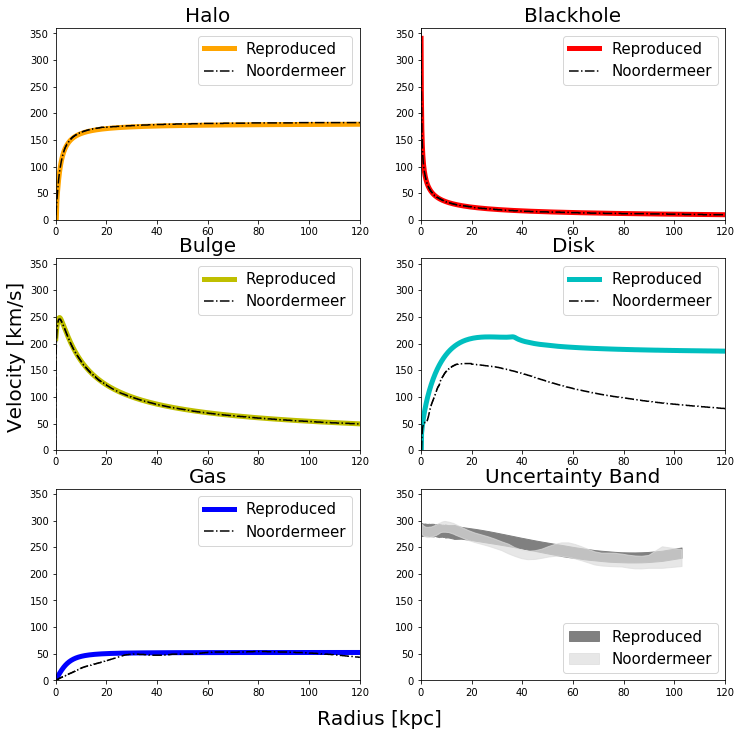

In [33]:
#x = np.linspace(0,10,100)
#y = 3*x
fig, axs = plt.subplots(3,2,figsize=(12,12))
#fig, axs = plt.subplots(2, 2)

ax1 = axs[0, 0]
ax1.plot(rval,nf.h_v(rval,load=True),color='orange',label='Reproduced',linewidth=5)
ax1.plot(r_dm_nord, v_dm_nord, color='k', linestyle='-.', label='Noordermeer') 
ax1.legend(loc="upper right", prop={'size': 15})
ax1.set_title('Halo', size=20)

ax2 = axs[0, 1]
ax2.plot(rval,nf.bh_v(rval,load=True),color='r',label='Reproduced',linewidth=5)
ax2.plot(r_bh_nord, v_bh_nord, color='k', linestyle='-.', label='Noordermeer') 
ax2.legend(loc="upper right", prop={'size': 15})
ax2.set_title('Blackhole', size=20)

ax3 = axs[1,0]
ax3.plot(rval,nf.b_v(rval,load=True),color='y',label='Reproduced',linewidth=5)
ax3.plot(r_b_nord, v_b_nord, color='k', linestyle='-.', label='Noordermeer') 
ax3.legend(loc="upper right", prop={'size': 15})
ax3.set_title('Bulge', size=20)

ax4 = axs[1,1]
ax4.plot(rval,nf.d_v(rval,load=True),color='c',label='Reproduced',linewidth=5)
ax4.plot(r_d_nord, v_d_nord, color='k', linestyle='-.', label='Noordermeer') 
ax4.legend(loc="upper right", prop={'size': 15})
ax4.set_title('Disk', size=20)





ax5 = axs[2,1]
plt.fill_between(r_dat,zgreyb_below,zgreyb_above,color='gray', label='Reproduced')
plt.fill_between(r_dat,greyb_bottom(r_dat),greyb_top(r_dat),color='#dddddd', label='Noordermeer', alpha=0.7)
#plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='ko')    #data points
ax5.legend(loc="lower right", prop={'size': 15})
ax5.set_title('Uncertainty Band', size=20)

ax6 = axs[2,0]
#plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data') 
ax6.plot(rval, 1.75*g_v1(rval),color='blue',label='Reproduced',linewidth=5)
ax6.plot(r_gas, v_gas, color='k', linestyle='-.', label='Noordermeer') 
#ax6.set_ylim([0, 100])
ax6.legend(loc="upper right", prop={'size': 15})
ax6.set_title('Gas', size=20)


#xs[0, 0].plot
#axs[0, 0].set_title('Axis [0,0]')
#axs[0, 1].plot(x, y, 'tab:orange')
#axs[0, 1].set_title('Axis [0,1]')
#axs[1, 0].plot(x, -y, 'tab:green')
#axs[1, 0].set_title('Axis [1,0]')
#axs[1, 1].plot(x, -y, 'tab:red')
#axs[1, 1].set_title('Axis [1,1]')

fig.text(0.5, 0.08, 'Radius [kpc]', ha='center', va='center',fontsize=20)
fig.text(0.08, 0.5, 'Velocity [km/s]', ha='center', va='center', rotation='vertical',fontsize=20)
for ax in axs.flat:  #for loop for easier organization; helpful if many supblots
    #ax1.set(xlabel='x-dfdf', ylabel='y-dfdsf')
   # ax.set(xlabel='radius [kpc]', ylabel='Velocity [km/s]')
    ax.set_xlim([0, 120])
    ax.set_ylim([0, 360])

# Hide x labels and tick labels for top plots and y ticks for right plots.

plt.savefig('Reproducibility_Paper_Figures/components_comparison.png')